# Loan Prediction

#### Column Description
* **Loan_ID** -	Unique Loan ID
* **Gender** -	Male/ Female
* **Married** -	Applicant married (Y/N)
* **Dependents** -	Number of dependents
* **Education** -	Applicant Education (Graduate/ Under Graduate)
* **Self_Employed** -	Self employed (Y/N)
* **ApplicantIncome** -	Applicant income
* **CoapplicantIncome** -	Coapplicant income
* **LoanAmount** -	Loan amount in thousands
* **Loan_Amount_Term** -	Term of loan in months
* **Credit_History** -	credit history meets guidelines
* **Property_Area** -	Urban/ Semi Urban/ Rural
* **Loan_Status** -	(Target) Loan approved (Y/N)


## Set Up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('./data/train.csv')
print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [2]:
test = pd.read_csv('./data/test.csv')
print(test.shape)
test.head()

(367, 12)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Examining the Data

In [3]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [4]:
# Unique text values per column
obj_cols = list(train.columns[train.dtypes=='object'])
obj_cols.remove('Loan_ID')
obj_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [5]:
# Unique values of each column with 'object' data types
# Will help determine how to preprocess them into number data types
for col in obj_cols:
    print(f"{col}:")
    print(f"{train[col].unique()}\n")

Gender:
['Male' 'Female' nan]

Married:
['No' 'Yes' nan]

Dependents:
['0' '1' '2' '3+' nan]

Education:
['Graduate' 'Not Graduate']

Self_Employed:
['No' 'Yes' nan]

Property_Area:
['Urban' 'Rural' 'Semiurban']

Loan_Status:
['Y' 'N']



## Preprocessing Columns & Values

In [6]:
# Make copy of original dataset
ntrain = train.copy()
print(ntrain.shape)
ntrain.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
# Collect all the columns with 'object' data types (except Loan ID) for preprocessing
obj_cols = [col for col in train.columns[train.dtypes=='object']]
obj_cols.remove('Loan_ID')
obj_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [8]:
# Binary Encoding the following columns:
# (Generally 0 means 'no' or implies negation, while 1 the opposite)

# Gender
ntrain.loc[(ntrain.Gender == 'Male')|(ntrain.Gender.isnull()), 'Gender'] = 0
ntrain.loc[ntrain.Gender == 'Female', 'Gender'] = 1
ntrain.Gender = ntrain.Gender.astype(float)
print(ntrain.shape)

# Married
ntrain.loc[ntrain.Married == 'No', 'Married'] = 0
ntrain.loc[(ntrain.Married == 'Yes')|(ntrain.Married.isnull()), 'Married'] = 1
ntrain.Married = ntrain.Married.astype(float)
print(ntrain.shape)

# Dependents
# Creat a new column called 'has_child'
ntrain['has_child'] = 1
ntrain.loc[(ntrain.Dependents.isnull())|(ntrain.Dependents=='0'),'has_child'] = 0
ntrain.drop('Dependents', axis=1, inplace=True)

# Education
ntrain['graduate'] = 1
ntrain.loc[(ntrain.Education.isnull())|(ntrain.Education=='Not Graduate'),'graduate'] = 0
ntrain.drop('Education', axis=1, inplace=True)

# Self_Employed
ntrain.loc[(ntrain.Self_Employed == 'No')|(ntrain.Self_Employed.isnull()), 'Self_Employed'] = 0
ntrain.loc[ntrain.Self_Employed == 'Yes', 'Self_Employed'] = 1
ntrain.Self_Employed = ntrain.Self_Employed.astype(float)
print(ntrain.shape)

# Loan_Status
ntrain.loc[ntrain.Loan_Status == 'N', 'Loan_Status'] = 0
ntrain.loc[(ntrain.Loan_Status == 'Y')|(ntrain.Loan_Status.isnull()), 'Loan_Status'] = 1
print(ntrain.shape)

# Credit_History
ntrain.loc[ntrain.Credit_History.isnull(), 'Credit_History'] = 1
ntrain.Credit_History = ntrain.Credit_History.astype(float)
print(ntrain.shape)

ntrain.head()

(614, 13)
(614, 13)
(614, 13)
(614, 13)
(614, 13)


,Loan_ID,Gender,Married,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,has_child,graduate
0,LP001002,0.0,0.0,0.0,5849,0.0,NaN,360.0,1.0,Urban,1,0,1
1,LP001003,0.0,1.0,0.0,4583,1508.0,128.0,360.0,1.0,Rural,0,1,1
2,LP001005,0.0,1.0,1.0,3000,0.0,66.0,360.0,1.0,Urban,1,0,1
3,LP001006,0.0,1.0,0.0,2583,2358.0,120.0,360.0,1.0,Urban,1,0,0
4,LP001008,0.0,0.0,0.0,6000,0.0,141.0,360.0,1.0,Urban,1,0,1


In [9]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()

# Property_Area
ntrain.Property_Area = ntrain.Property_Area.astype(str)
results = binarizer.fit_transform(ntrain.Property_Area)
property_area_encoded = pd.DataFrame(results, columns=binarizer.classes_)
print(ntrain.shape)

ntrain = pd.concat([ntrain, property_area_encoded], axis=1, sort=False)
ntrain.drop('Property_Area', axis=1, inplace=True)

ntrain.head()

(614, 13)


,Loan_ID,Gender,Married,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,has_child,graduate,Rural,Semiurban,Urban
0,LP001002,0.0,0.0,0.0,5849,0.0,NaN,360.0,1.0,1,0,1,0,0,1
1,LP001003,0.0,1.0,0.0,4583,1508.0,128.0,360.0,1.0,0,1,1,1,0,0
2,LP001005,0.0,1.0,1.0,3000,0.0,66.0,360.0,1.0,1,0,1,0,0,1
3,LP001006,0.0,1.0,0.0,2583,2358.0,120.0,360.0,1.0,1,0,0,0,0,1
4,LP001008,0.0,0.0,0.0,6000,0.0,141.0,360.0,1.0,1,0,1,0,0,1


In [10]:
ntrain.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Loan_Status           0
has_child             0
graduate              0
Rural                 0
Semiurban             0
Urban                 0
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

X = ntrain.iloc[:,1:-1]
y = ntrain['Loan_Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=77)

In [12]:
from sklearn.impute import SimpleImputer

# imputation
imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_val = pd.DataFrame(imputer.transform(X_val))

imputed_X_train.columns = X_train.columns
imputed_X_val.columns = X_val.columns

imputed_X_train.head()

,Gender,Married,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,has_child,graduate,Rural,Semiurban
0,0.0,1.0,0.0,3406.0,4417.0,123.0,360.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,5708.0,5625.0,187.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,2500.0,0.0,55.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,12500.0,3000.0,320.0,360.0,1.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,5316.0,0.0,136.0,360.0,1.0,1.0,0.0,1.0,0.0,0.0


In [19]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def score_dataset(X_train, X_val, y_train, y_val):
    model = RandomForestRegressor(n_estimators = 10, random_state=77)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    return mean_absolute_error(y_val, prediction)

score_dataset(imputed_X_train, imputed_X_val, y_train, y_val)

0.0

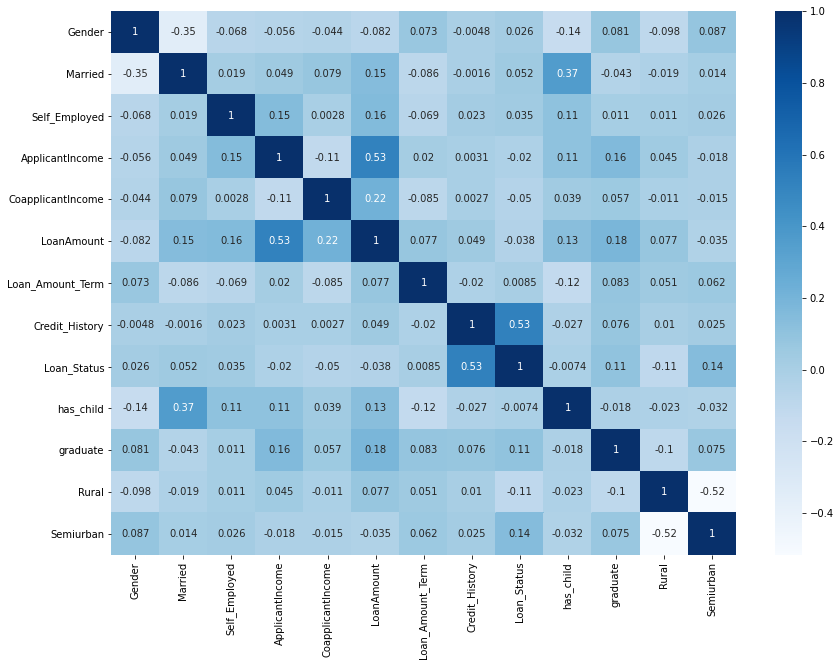

In [15]:
corr=imputed_X_train.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap="Blues")